In [79]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, KFold, LeaveOneOut
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.decomposition import PCA
import umap
import json
import cupy
from tqdm import tqdm
from gtfparse import read_gtf

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm

from sklearn import svm
from xgboost import XGBRegressor


from sklearn.metrics import root_mean_squared_error as RMSE


In [80]:
fdir_raw = Path("../data/raw/")
fdir_processed = Path("../data/interim")
fdir_traintest = Path("../data/processed") / 'sex'
fdir_external = Path("../data/external")
ml_models_fdir = Path("../models")

use_CV = True

model_type = 'catboost'
model_type = 'xgboost'
# model_type = 'knn'

feature_importance_method = 'native'
feature_importance_method = 'SHAP'

n_features = 0

# value_to_predict = 'population'
value_to_predict = 'Age'

organ = "HEART"
organ = "BRAIN0"
organ = "BRAIN1"

sex = 'male'
# sex = 'female'

In [81]:
fdir_processed / f'{organ}.preprocessed.h5'

PosixPath('../data/interim/BRAIN1.preprocessed.h5')

In [82]:
# gtf_rawdata = read_gtf(fdir_raw / 'all_transcripts_strigtie_merged.gtf')
# gtf_data = gtf_rawdata.to_pandas()
# gtf_data = gtf_data.set_index('transcript_id')
# gtf_data['transcript_id'] = gtf_data.index

# gtf_data

In [83]:
data = pd.read_hdf(fdir_processed / f'{organ}.preprocessed.h5', key="data")
data_header = pd.read_hdf(fdir_processed / f'{organ}.preprocessed.h5', key="header")

data = data.iloc[:, np.argwhere(np.sum(data > 0, axis=0) > 18).ravel()]
# data
if organ == "BRAIN1":
    data_header['sex'] = data_header['gender'] 


data = data.loc[data_header['sex'] == sex]
data_header = data_header.loc[data_header['sex'] == sex]



In [84]:
# eval_organ = "BRAIN0"
# eval_organ = "BRAIN1"
# eval_organ = 'HEART'
eval_organ = organ

fname = next((fdir_external / eval_organ / 'reg').glob("*processed.h5"))
fname = fname.name
data_eval = pd.read_hdf(fdir_external / eval_organ / 'reg' / fname, index_col=0)
data_eval_header = pd.read_csv(fdir_external / eval_organ / 'reg' / 'SraRunTable.txt', sep=',')
data_eval_header.set_index("Run", inplace=True)

if eval_organ == "BRAIN1":
    data_eval_header['sex'] = data_eval_header['gender'] 

data_eval_header = data_eval_header.loc[data_eval_header['sex'] == sex]
data_eval = data_eval.loc[(data_eval_header['sex'] == sex).index]


In [85]:
common_transcripts = data.columns.intersection(data_eval.columns)

data_eval = data_eval[common_transcripts]
data = data[common_transcripts]
data

,ENST00000003912.7,ENST00000004103.8,ENST00000005340.10,ENST00000006658.11,ENST00000011473.6,ENST00000012134.7,ENST00000019019.6,ENST00000040877.2,ENST00000043402.8,ENST00000070846.11,...,MSTRG.9920.54,MSTRG.9929.23,MSTRG.9929.7,MSTRG.993.1,MSTRG.9947.1,MSTRG.9948.7,MSTRG.9968.1,MSTRG.9975.19,MSTRG.9996.5,MSTRG.9996.8
SRR19147435,0.028958,0.000000,0.834745,1.847615,2.891965,1.902646,0.172238,0.695127,0.000000,0.000000,...,0.000000,0.358886,0.158193,1.170810,0.000000,0.395059,0.000000,0.413721,1.591116,0.348319
SRR19147436,0.026559,0.000000,0.543138,0.000000,0.000000,2.253369,0.000000,0.012604,0.080319,1.091911,...,0.000000,0.000000,0.000000,2.064195,0.000000,0.398859,0.403035,0.000000,2.387390,1.570008
SRR19147437,0.048312,0.000000,0.000000,0.000000,0.000000,4.136106,3.016967,0.300410,0.000000,0.562984,...,0.000000,1.130694,0.834678,2.205190,0.534288,0.150727,0.169303,0.000000,2.027091,1.063526
SRR19147438,0.000000,0.000000,0.000000,0.000000,3.418941,0.000000,1.557123,0.000000,0.000000,1.654769,...,1.368054,0.930568,0.554803,0.000000,0.000000,0.155173,0.019762,0.000000,0.000000,0.000000
SRR19147439,0.046003,0.454039,1.029648,2.566160,2.321773,2.573854,0.000000,0.521783,1.571417,0.651481,...,0.208688,0.000000,0.608604,1.677697,0.000000,0.652186,1.153167,0.068222,0.000000,2.014083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR19147641,0.093393,0.000000,0.000000,2.122827,0.000000,2.076210,0.337818,0.106611,0.197119,0.000000,...,0.000000,0.287268,0.101688,0.014515,0.605504,0.297676,0.375136,0.125045,1.844473,0.554188
SRR19147642,0.054792,0.911607,0.690133,2.784186,1.158201,0.000000,0.172868,0.794288,0.130496,0.000000,...,0.000000,0.546777,0.000001,0.791522,0.681230,0.984555,0.000000,2.262697,0.000000,0.000000
SRR19147644,0.048369,0.160150,0.561373,2.631126,0.000000,2.055369,2.143611,0.252948,1.506372,0.000000,...,0.000000,0.000000,0.375822,0.658635,0.287741,0.265036,0.082748,0.000000,2.765646,0.221781
SRR19147646,0.050603,0.986116,0.000000,1.135551,2.748827,0.000000,1.214124,0.176268,0.172753,0.000000,...,0.000000,0.263513,0.280844,0.483761,0.849196,1.100405,0.882657,0.254543,1.068739,0.462035


In [86]:
# y = data_header[value_to_predict]
# X = data.values

y = data_header.loc[data_header['sex'] == sex][value_to_predict]
X = data.loc[data_header['sex'] == sex].values
y

SRR19147435    28
SRR19147436    27
SRR19147437    33
SRR19147438    40
SRR19147439    45
               ..
SRR19147641    48
SRR19147642    49
SRR19147644    49
SRR19147646    52
SRR19147648    49
Name: Age, Length: 150, dtype: int64

In [87]:
from scipy.stats import spearmanr

rhos = []
pvalues = []

for i in tqdm(range(X.shape[1])):
    # rho, pvalue = spearmanr(X[:, i], y)
    rho, pvalue = spearmanr(X[:, i], y)
    rhos.append(rho)
    pvalues.append(pvalue)
# rho, pvalue = spearmanr(X, y.values.reshape(1,-1), axis=1)


100%|██████████| 17915/17915 [00:12<00:00, 1434.63it/s]


In [88]:
# np.argwhere(np.array(pvalues) < 0.05).shape
unsignificant_corr_ids = np.argwhere(np.array(pvalues) > 0.05)
# unsignificant_corr_ids

rhos = np.array(rhos)
rhos[unsignificant_corr_ids] = 0
rhos[np.argwhere(X.mean(axis=0) == 0)] = 0


In [89]:
corr_threshold = 0.96
corr_threshold = 0.5
corr_threshold = 0.1

if np.abs(rhos).max() > corr_threshold:
    sorted_corr_border = np.argwhere(np.sort(np.abs(rhos))[::-1] > corr_threshold).max()
    sorted_corr_ids = np.argsort(np.abs(rhos))[::-1][:sorted_corr_border]
    # np.sort(np.abs(rhos))[::-1][:sorted_corr_border], sorted_corr_ids
else:
    sorted_corr_ids = []

In [90]:
# model = XGBRegressor()

# X = data.values
# y = data_header['Age'].loc[data_header['sex'] == sex].values

# # model.fit(RobustScaler().fit_transform(X),  y)
# model.fit(X,  y)
# importances = model.feature_importances_

# sorted_corr_ids = np.argsort(importances).ravel()[::-1][:50]

In [91]:
# plt.figure(figsize=(16,6))
sns.scatterplot(
    y=np.abs(rhos[sorted_corr_ids]), 
    x=data.columns[sorted_corr_ids],
    )
plt.xticks(rotation=90)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

In [ ]:
data.columns[sorted_corr_ids], len(sorted_corr_ids) 

(Index(['MSTRG.24372.1', 'ENST00000562938.6', 'MSTRG.30797.34',
        'ENST00000636170.1', 'ENST00000368732.5', 'ENST00000414562.1',
        'MSTRG.29364.2', 'MSTRG.27407.13', 'MSTRG.21565.34',
        'ENST00000390517.1',
        ...
        'MSTRG.15201.6', 'ENST00000641834.2', 'MSTRG.35493.2', 'MSTRG.31745.5',
        'MSTRG.3370.10', 'MSTRG.14239.13', 'ENST00000654988.1',
        'ENST00000476562.5', 'MSTRG.29498.18', 'MSTRG.28762.46'],
       dtype='object', length=1034),
 1034)

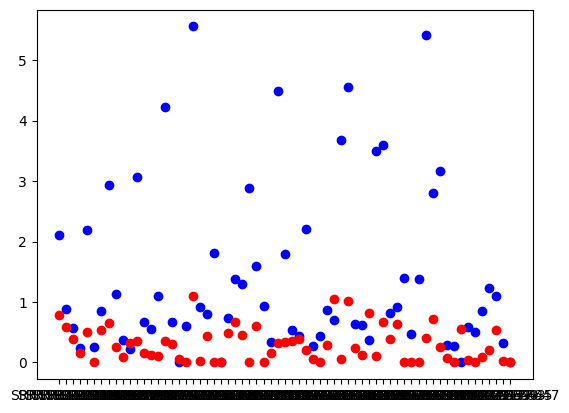

In [ ]:
plt.plot(data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][0]], 'bo')
plt.plot(data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][1]], 'ro')

In [ ]:
data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][0]]

SRR19147434    2.106808
SRR19147442    0.878456
SRR19147446    0.566716
SRR19147447    0.243563
SRR19147449    2.192655
                 ...   
SRR19147639    0.856650
SRR19147640    1.235301
SRR19147643    1.103090
SRR19147645    0.324511
SRR19147647    0.000000
Name: MSTRG.24372.1, Length: 65, dtype: float32

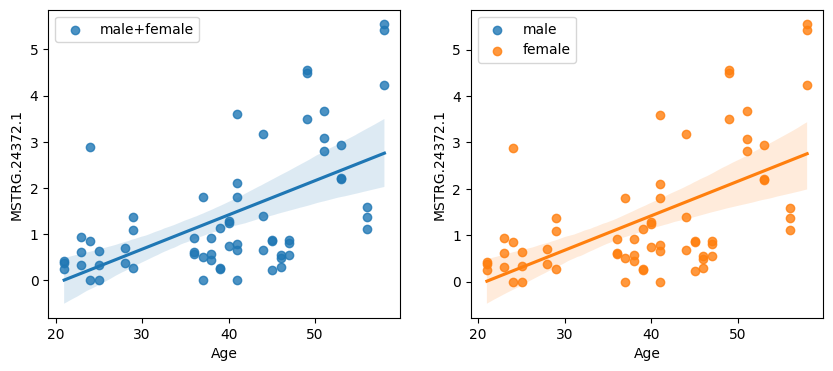

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
sns.regplot(y=data[data.columns[sorted_corr_ids[0]]], x=data_header['Age'], ax=axs[0], label='male+female')
sns.regplot(y=data[data.columns[sorted_corr_ids[0]]].loc[data_header['sex'] == 'male'], x=data_header['Age'].loc[data_header['sex'] == 'male'], ax=axs[1], 
            label='male')
sns.regplot(y=data[data.columns[sorted_corr_ids[0]]].loc[data_header['sex'] == 'female'], x=data_header['Age'].loc[data_header['sex'] == 'female'], ax=axs[1], 
            label='female')
axs[0].legend()
axs[1].legend()

In [ ]:


# n_features = 5
# n_features = -1

# sex = 'male'

print(data.shape[0])

for n_features in range(1, np.min([data.shape[0]+1, len(sorted_corr_ids)+1, 20])):
# for n_features in [5]:

    X = data[data.columns[sorted_corr_ids[:n_features]]].values
    y = data_header['Age'].loc[data_header['sex'] == sex].values

    # print(X.shape)
    print(f"{n_features=}")
    
    # cv = StratifiedKFold(n_splits=5)
    cv = LeaveOneOut()

    preds = []
    vals  = []
    gls_preds = []
    
    rmses = []
    r2s = []

    for i, (train, val) in tqdm(enumerate(cv.split(X, y))):
        X_train = X[train]
        y_train = y[train]
        X_test = X[val]
        y_test = y[val]

        # train_scaler = RobustScaler().fit(X_train)
        # test_scaler = RobustScaler().fit(X_test)
        # X_train = train_scaler.transform(X_train)
        # X_test = test_scaler.transform(X_test)

        X_train_ = X_train
        y_train_ = y_train
        
        X_val = X_test
        y_val = y_test
        
        # X_val = data_eval[data_eval.columns[sorted_corr_ids[:n_features]]].values
        # y_val = data_eval_header['Age'].loc[data_eval_header['sex']==sex].values


        model = svm.SVR(kernel='linear')
        # model = svm.LinearSVR(loss='squared_epsilon_insensitive')
        # model = LinearRegression()
        # model = Ridge()
        # model = XGBRegressor()
        # model = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
        #                      param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 20)})    
        
        model.fit(X_train_, y_train_)
        pred = model.predict(X_val)
        
        preds.append(pred)
        vals.append(y_val)
                
        X_train_ = sm.add_constant(X_train_)
        X_test = sm.add_constant(X_test, has_constant='add')
        
        mod = sm.GLS(y_train_, X_train_).fit()
        gls_pred = mod.predict(X_test)
        gls_preds.append(gls_pred)
        
        # rmses.append(
        #     RMSE(pred, y_val)
        # )
        # r2s.append(
        #     r2_score(y_val, pred)
        # )

    print("RMSE: ", RMSE(preds, vals))
    # print("RMSE: ", RMSE(gls_preds, vals))
    print("R2: ", r2_score(vals, preds))
    # print("R2: ", r2_score(vals, gls_preds))
    
    # print("RMSE: ", np.mean(rmses))
    # print("R2: ", np.mean(r2s))
    
    # print(data.columns[sorted_corr_ids[:n_features]])
    print("-"*20)
    # print(model.coef_)
    # print(model.intercept_)

    # plt.plot(vals, "bo")
    # plt.plot(preds, "ro")
    # plt.show()

model.coef_

65
n_features=1


65it [00:00, 1135.32it/s]


RMSE:  8.885525335594119
R2:  0.3034421932634339
--------------------
n_features=2


65it [00:00, 1455.62it/s]


RMSE:  8.788889956932175
R2:  0.3185107671863219
--------------------
n_features=3


65it [00:00, 1432.60it/s]


RMSE:  8.473955308668767
R2:  0.3664756917616605
--------------------
n_features=4


65it [00:00, 1420.58it/s]


RMSE:  7.893622899619121
R2:  0.4502772693439441
--------------------
n_features=5


65it [00:00, 1430.72it/s]


RMSE:  7.8819089477799045
R2:  0.45190761011272396
--------------------
n_features=6


65it [00:00, 1372.30it/s]


RMSE:  7.482492380858472
R2:  0.5060494066067751
--------------------
n_features=7


65it [00:00, 1294.43it/s]


RMSE:  7.08911596357727
R2:  0.5566210137237785
--------------------
n_features=8


65it [00:00, 1284.29it/s]


RMSE:  7.347425329455806
R2:  0.5237211381394495
--------------------
n_features=9


65it [00:00, 1262.33it/s]


RMSE:  7.136157874323937
R2:  0.5507171471512474
--------------------
n_features=10


65it [00:00, 925.85it/s]


RMSE:  7.106557831649429
R2:  0.5544365745649495
--------------------
n_features=11


65it [00:00, 1206.74it/s]


RMSE:  7.243650082319062
R2:  0.537080078877786
--------------------
n_features=12


65it [00:00, 1162.49it/s]


RMSE:  7.455910420698176
R2:  0.5095527451998692
--------------------
n_features=13


65it [00:00, 1177.30it/s]


RMSE:  7.777908509003651
R2:  0.46627615575189985
--------------------
n_features=14


65it [00:00, 1167.29it/s]


RMSE:  7.248023753082014
R2:  0.5365208937874175
--------------------
n_features=15


65it [00:00, 1102.92it/s]


RMSE:  7.174683158569154
R2:  0.545853053207958
--------------------
n_features=16


65it [00:00, 1135.72it/s]


RMSE:  6.911932160480887
R2:  0.5785074732039608
--------------------
n_features=17


65it [00:00, 1145.59it/s]


RMSE:  7.121691120259983
R2:  0.5525369152783577
--------------------
n_features=18


65it [00:00, 827.02it/s]


RMSE:  6.707690755239106
R2:  0.6030489005680579
--------------------
n_features=19


65it [00:00, 1037.74it/s]

RMSE:  6.9847268906015385
R2:  0.5695826157659698
--------------------


array([[ 0.3206685 ,  1.94674133,  2.00504485,  2.61865789,  1.51093736,
         2.8057435 , -0.15448734,  2.21767844,  0.28159449,  2.4497236 ,
         2.52294591, -0.32620252, -2.14170165, -1.41550364, -1.11833381,
         1.37993046, -1.86666312,  1.75764166,  1.29342224]])

65
n_features=18


65it [00:00, 1180.64it/s]

RMSE:  6.707690755239106
R2:  0.6030489005680579


Text(0, 0.5, 'ground true age')

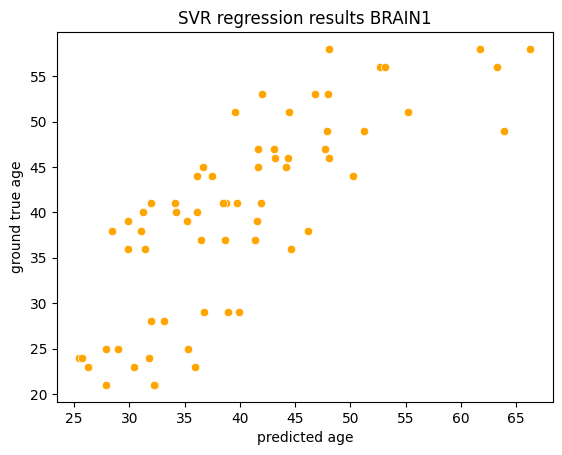

In [78]:


# n_features = 5
# n_features = -1

# sex = 'male'
print(data.shape[0])

n_features = 18

X = data[data.columns[sorted_corr_ids[:n_features]]].values
y = data_header['Age'].loc[data_header['sex'] == sex].values

# print(X.shape)
print(f"{n_features=}")

# cv = StratifiedKFold(n_splits=5)
cv = LeaveOneOut()

preds = []
vals  = []
gls_preds = []

rmses = []
r2s = []

for i, (train, val) in tqdm(enumerate(cv.split(X, y))):
    X_train = X[train]
    y_train = y[train]
    X_test = X[val]
    y_test = y[val]

    # train_scaler = RobustScaler().fit(X_train)
    # test_scaler = RobustScaler().fit(X_test)
    # X_train = train_scaler.transform(X_train)
    # X_test = test_scaler.transform(X_test)

    X_train_ = X_train
    y_train_ = y_train
    
    X_val = X_test
    y_val = y_test
    
    model = svm.SVR(kernel='linear')
    # model = svm.LinearSVR(loss='squared_epsilon_insensitive')
    # model = LinearRegression()
    # model = Ridge()
    # model = XGBRegressor()
    # model = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
    #                      param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 20)})    
    
    model.fit(X_train_, y_train_)
    pred = model.predict(X_val)
    
    preds.append(pred)
    vals.append(y_val)

print("RMSE: ", RMSE(preds, vals))
# print("RMSE: ", RMSE(gls_preds, vals))
print("R2: ", r2_score(vals, preds))

model.coef_

colors = {
    'male': 'blue',
    "female": "orange"
}

g = sns.scatterplot(x=np.array(preds).ravel(), y=np.array(vals).ravel(), color=colors[sex])
g.set_title(f"SVR regression results {organ}")
g.set_xlabel("predicted age")
g.set_ylabel("ground true age")


In [ ]:
n_features = 5

X = data[data.columns[sorted_corr_ids[:n_features]]].values
y = data_header['Age'].loc[data_header['sex'] == sex].values

X_total = X
X_total = RobustScaler().fit_transform(X)

model.fit(X_total, y)
pred = model.predict(X_total)
print(pred)


mod = sm.GLS(y, sm.add_constant(X_total)).fit()
gls_pred = mod.predict(sm.add_constant(X_total))
print(gls_pred)

print("RMSE: ", RMSE(y, pred))
print("RMSE: ", RMSE(y, gls_pred))

print("-"*20)

X_eval = data_eval[data.columns[sorted_corr_ids[:n_features]]]
# X_eval = RobustScaler().fit_transform(X_eval)

y_predicted = model.predict(X_eval)
# print(y_predicted.astype(int), data_eval_header['Age'].values)
# 
y_pred_gls = mod.predict(sm.add_constant(X_eval))
# print(y_pred_gls.astype(int), data_eval_header['Age'].values)

print("RMSE eval: ", RMSE(data_eval_header['Age'].values, y_predicted))
print("RMSE eval: ", RMSE(data_eval_header['Age'].values, y_pred_gls))


print("R2: ", r2_score(data_eval_header['Age'].values, y_predicted))
print("R2: ", r2_score(data_eval_header['Age'].values, y_pred_gls))

# y_predicted = mod.predict(sm.add_constant(X_eval))

In [ ]:
transcripts = data.columns[sorted_corr_ids[:n_features]]
print(transcripts.values)
print(model.coef_)
gtf_data.loc[transcripts].drop_duplicates()

In [ ]:
gtf_data.loc[transcripts, 'gene_name'].drop_duplicates().values

In [ ]:
# from ucsc.api import Hub, Genome, Track, TrackSchema, Chromosome, Sequence

# genome = Genome.find('wuhCor1')

# print(genome.genomeName)
# print(genome.organism)
# print(genome.__dict__) # to return all attributes in the object

# track = genome.tracks[0]

# ---------------------------------

# # track = genome.findTrackBy('shortLabel','Microdeletions')
# # (dir(track))
# # sequence = Sequence.get(genome='hg38', chrom='chr1')
# # sequence.dna

# genome = Genome.find('hg38')
# tracks = genome.tracks

# for track in tracks:
#     print(track.trackName)

In [ ]:
import requests, json
headers = {"accept": "application/json"}

genes_dict = {}

for gene_name in gtf_data.loc[transcripts, 'gene_name'].drop_duplicates().values: 
    print(f"{gene_name=}")
    url = f"https://www.encodeproject.org/search/?searchTerm={gene_name}"
    
    response = requests.get(url, headers=headers)
    search_results = response.json()
    
    for result in search_results["@graph"]:
        if "organism" in result.keys():
            if (result['organism']['scientific_name'] == 'Homo sapiens'):
                if "name" in result.keys():
                    print(result['name'])
                    print(result['title'])
                    print(result['geneid'])
                    print("-"*10)
                    genes_dict[gene_name] = result
                    break
        else:
            print(result)
            

    # print(search_results["@graph"])

In [ ]:
for key in genes_dict.keys():
    print(genes_dict[key]['geneid'])

In [ ]:
from Bio import Entrez


In [ ]:
Entrez.email = "zodelheim@gmail.com"
handle = Entrez.einfo() # or esearch, efetch, ...
record = Entrez.read(handle)
handle.close()
record


In [ ]:
for key in genes_dict.keys():
    print(genes_dict[key]['geneid'])
    handle = Entrez.efetch(db="gene", id=str(genes_dict[key]['geneid']), retmode='xml')
    records = Entrez.parse(handle)
    for record in records:
        if "Entrezgene_summary" in record.keys():
            print(record['Entrezgene_summary'])
        # each record is a Python dictionary or list.
        # print(record.keys())
        print(record['Entrezgene_type'])
        print(key)
        print("-"*10)

    handle.close()

In [ ]:
genes_dict['SLC9A7P1']

In [ ]:
# record['Entrezgene_summary']
print(record.keys())
# record['Entrezgene_comments']
# genes_dict[key]['geneid']

In [ ]:
handle = Entrez.esearch(db='gene', term='PACS2')
records = Entrez.read(handle)
handle.close()

In [ ]:
records['IdList']